In [1]:
from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from accretion import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


## Accretion of matter as per eq. (10) and (11) of https://arxiv.org/pdf/2003.12589.pdf

def f(t, m):
    z = t
    y = np.array(m, dtype = np.longdouble)
    if z < 0 or z == 0:
        print("i =",   i, ",", "z =", z)

    if v_relative == 0:
        def v_eff(z):    #with the approximation of either v_rel = 0 or v_rel << c_s(z)
            β = 1.72
            z_dec = 130
            return 5.74e3 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β))) * (yr/pc)
    
    elif v_relative == speed_of_sound:
         def v_eff(z):    #with the approximation of v_rel = c_s(z)
            β = 1.72
            z_dec = 130
            return np.sqrt(2) * 5.74e3 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β))) * (yr/pc)
    
    else:
        def v_eff(z):    #with v_rel given by Eq.(7) of https://arxiv.org/pdf/1707.04206.pdf
            def c_s(z):
                β = 1.72
                z_dec = 130
                return  5.74e3 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β))) * (yr/pc)
            def v_rel(z):
                return  5.74e3 * (yr/pc) * np.minimum(1, (1+z/1000)) * (30e3/5.74e3)
            return np.sqrt(v_rel(z)**2 + c_s(z)**2)

    
    def λ(z, m):
        def β_cap(z, m):
            x_e = 1e-3
            return 1e-4 * y * (((1+z)/1000)**(3/2)) *  ((5.74e3 * (yr/pc)/v_eff(z))**3) * [0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2))]
        def x_cr(z, m):
            return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
        return np.exp((9/2)/ (3 + β_cap(z, m)*(3/4))) * (x_cr(z, m)**2)
    
    
    def dt_dz(z):
        x = ((Ω_r0 * ((1 + z)**6)) + (Ω_m0 * ((1 + z)**5)))
        return  - np.sqrt(3/(8 * π * G * ρ_c0)) * (x**(-1/2))
    
    
    
    if De_Luca == True:
        def m_dot(z, m):  #Eq.(11) in https://arxiv.org/abs/2003.12589
            return   2.3e-2 * λ(z, m) * (((1+z)/1000)**3) *  y * ((5.74e3 * (yr/pc)/v_eff(z))**3) 
        
    else:
        def m_dot(z, m):  #Eq.(11) in https://arxiv.org/abs/2003.12589
            return   2.7e-3 * λ(z, m) * (((1+z)/1000)**3) *  y * ((5.74e3 * (yr/pc)/v_eff(z))**3) 
    
    
    return 2e-3 *  m_dot(z, m) * (y/1e6) *  dt_dz(z)

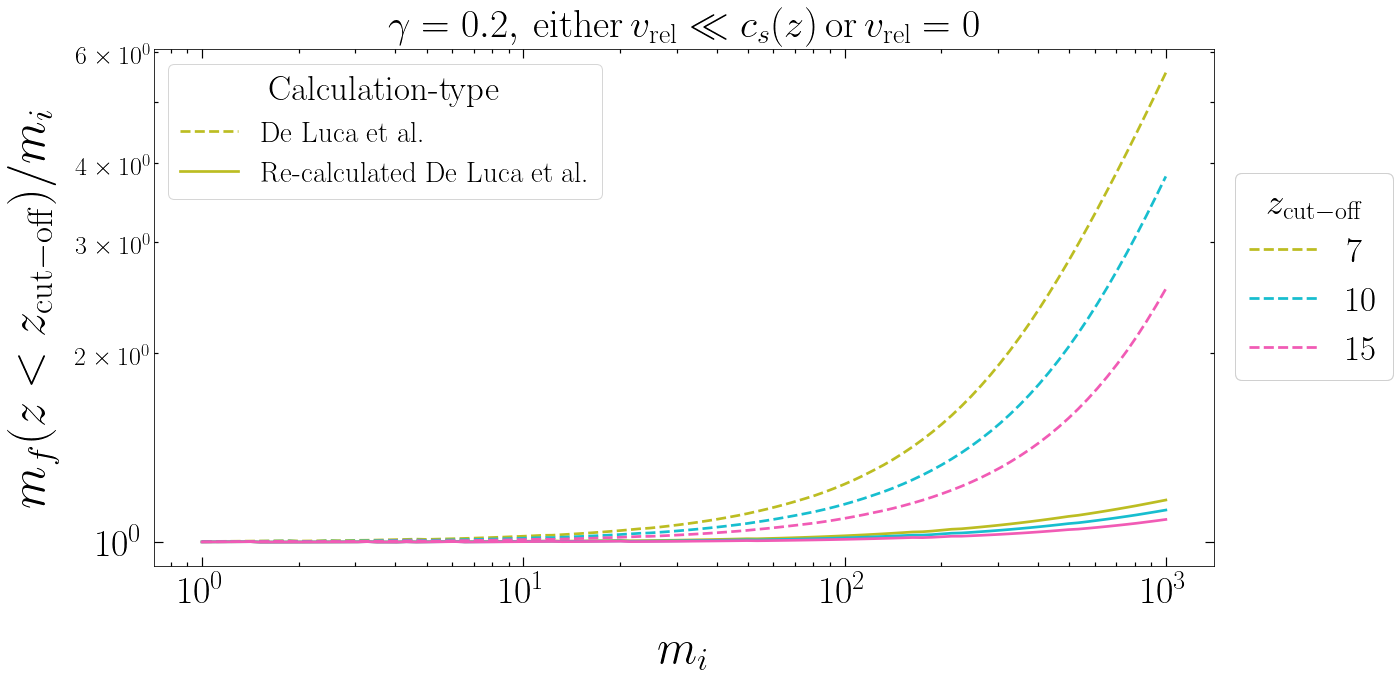

In [2]:
# Baryon accretion as per as per eq. (10) and (11) of Luca et. al https://arxiv.org/pdf/2003.12589.pdf 
# to upto z_cut-off = 5.
# Here, m_f(z < z_cut-off)/m_i implies  m_f(z = z_cut-off)/m_i.

m_spacing = 100
mi_arr = np.geomspace(1, 1e3, m_spacing)





fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_cut_arr = np.array([7, 10, 15])
mf_arr_Luca = np.zeros(len(mi_arr))
mf_arr_Luca_modified = np.zeros(len(mi_arr))
colors = ['C8', 'C9',  '#f15bb5']
plot_lines = []
N = 10




for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    v_relative = 0
    for j, m in enumerate(mi_arr):
        γ = 0.2
        z_1i = z_pbh(m,  γ)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        De_Luca = True
        sol1_Luca = solve_ivp(f, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        De_Luca = False
        sol1_Luca_modified = solve_ivp(f, t_span = [t1[0], t1[-1]], y0 = [y_1i], method = 'DOP853',  t_eval = t1)
        t1 = sol1_Luca.t
        y1_Luca = sol1_Luca.y[0]
        y1_Luca_modified = sol1_Luca_modified.y[0]


        z_2i = z_eq
        y_2i_Luca = y1_Luca[-1]
        y_2i_Luca_modified = y1_Luca_modified[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        De_Luca = True
        sol2_Luca = solve_ivp(f, t_span = [t2[0], t2[-1]], y0 = [y_2i_Luca], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        De_Luca = False
        sol2_Luca_modified = solve_ivp(f, t_span = [t2[0], t2[-1]], y0 = [y_2i_Luca_modified], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2_Luca.t
        y2_Luca = sol2_Luca.y[0]
        y2_Luca_modified = sol2_Luca_modified.y[0]




        z_3i = z_rec
        y_3i_Luca = y2_Luca[-1]
        y_3i_Luca_modified = y2_Luca_modified[-1]
        z_cut_off3 = z_th
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        De_Luca = True
        sol3_Luca = solve_ivp(f, t_span = [t3[0], t3[-1]], y0 = [y_3i_Luca], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        De_Luca = False
        sol3_Luca_modified = solve_ivp(f, t_span = [t3[0], t3[-1]], y0 = [y_3i_Luca_modified], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        t3 = sol3_Luca.t
        y3_Luca = sol3_Luca.y[0]
        y3_Luca_modified = sol3_Luca_modified.y[0]
        
        
        
        z_4i = z_th
        y_4i_Luca = y3_Luca[-1]
        y_4i_Luca_modified = y3_Luca_modified[-1]
        z_cut_off4 = 90
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        De_Luca = True
        sol4_Luca = solve_ivp(f, t_span = [t4[0], t4[-1]], y0 = [y_4i_Luca], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        De_Luca = False
        sol4_Luca_modified = solve_ivp(f, t_span = [t4[0], t4[-1]], y0 = [y_4i_Luca_modified], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        t4 = sol4_Luca.t
        y4_Luca = sol4_Luca.y[0]
        y4_Luca_modified = sol4_Luca_modified.y[0]

        
        
        
        z_5i = z_cut_off4
        y_5i_Luca = y4_Luca[-1]
        y_5i_Luca_modified = y4_Luca_modified[-1]
        z_cut_off5 = z_cut
        t5 = np.geomspace(z_5i, z_cut_off5, N)
        t_span = [t5[0], t5[-1]]
        De_Luca = True
        sol5_Luca = solve_ivp(f, t_span = [t5[0], t5[-1]], y0 = [y_5i_Luca], method = 'DOP853',  t_eval = t5, first_step = 1, max_step = 3)
        De_Luca = False
        sol5_Luca_modified = solve_ivp(f, t_span = [t5[0], t5[-1]], y0 = [y_5i_Luca_modified], method = 'DOP853',  t_eval = t5, first_step = 1, max_step = 3)
        t5 = sol5_Luca.t
        y5_Luca = sol5_Luca.y[0]
        y5_Luca_modified = sol5_Luca_modified.y[0]
        
        
        mf_arr_Luca[j] = y5_Luca[-1]
        mf_arr_Luca_modified[j] = y5_Luca_modified[-1]

    
    ax.loglog(mi_arr, np.divide(mf_arr_Luca, mi_arr), color = color, ls = '--')
    ax.loglog(mi_arr, np.divide(mf_arr_Luca_modified, mi_arr), color = color)
    
        
        
       
    
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$m_{i}$',fontsize = 47, labelpad = 20)

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["De Luca et al.", "Re-calculated De Luca et al."], title = 'Calculation-type',
        title_fontsize = 35, loc = 'upper left', prop = {"size":29})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 37, loc = (1.02, 0.36), prop = {"size":35})

ax.add_artist(legend1)
ax.add_artist(legend2)


plt.ylabel(r'$m_{f}(z < z_\mathrm{cut-off})/m_{i} $',fontsize = 50, labelpad = 16)
plt.xscale('log')
plt.title(r'$\gamma = 0.2, \, \mathrm{either} \, v_\mathrm{rel} \ll c_{s}(z)\, \mathrm{or} \, v_\mathrm{rel} = 0$', fontsize = 40, pad = 13)
plt.savefig('Luca_z_diff_cutoff1.pdf', bbox_inches = 'tight')
plt.show()

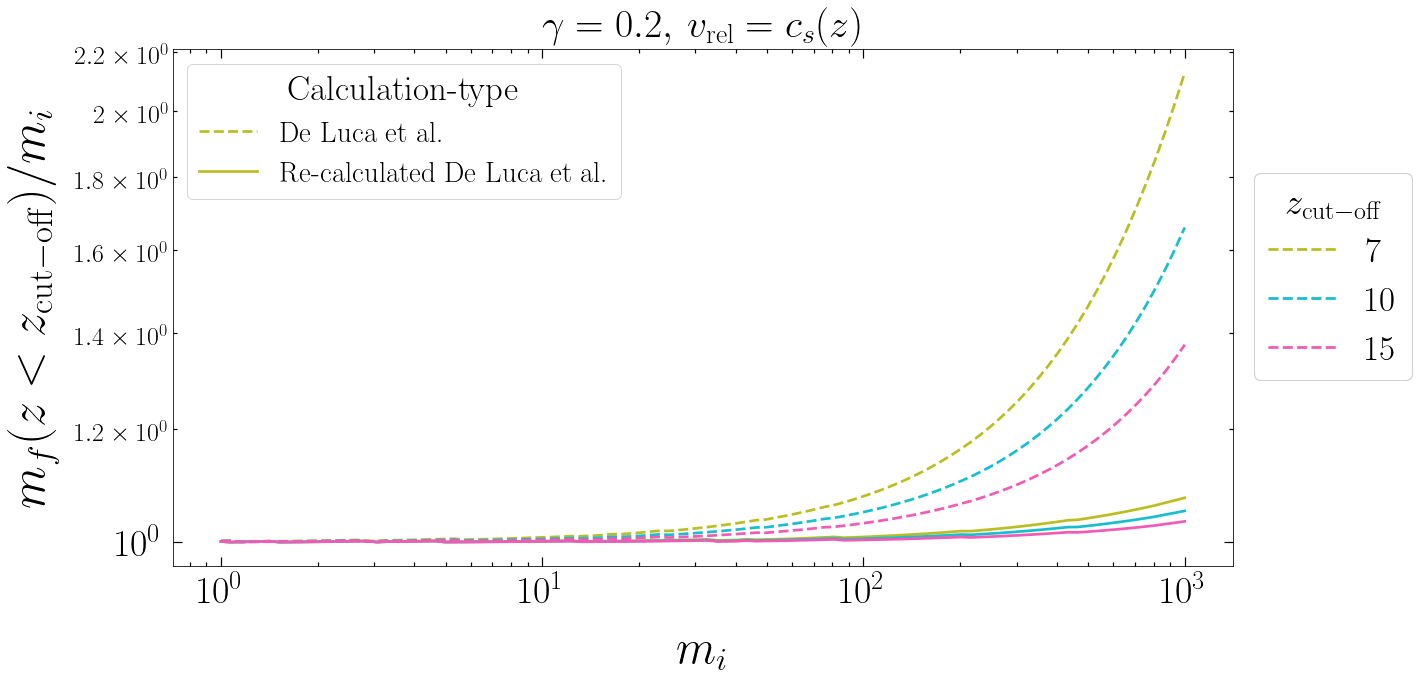

In [3]:
# Baryon accretion as per as per eq. (10) and (11) of Luca et. al https://arxiv.org/pdf/2003.12589.pdf 
# to upto z_cut-off = 5.
# Here, m_f(z < z_cut-off)/m_i implies  m_f(z = z_cut-off)/m_i.

m_spacing = 100
mi_arr = np.geomspace(1, 1e3, m_spacing)





fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_cut_arr = np.array([7, 10, 15])
mf_arr_Luca = np.zeros(len(mi_arr))
mf_arr_Luca_modified = np.zeros(len(mi_arr))
colors = ['C8', 'C9',  '#f15bb5']
plot_lines = []
N = 10



for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    speed_of_sound = True
    v_relative = speed_of_sound
    for j, m in enumerate(mi_arr):
        γ = 0.2
        z_1i = z_pbh(m,  γ)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        De_Luca = True
        sol1_Luca = solve_ivp(f, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        De_Luca = False
        sol1_Luca_modified = solve_ivp(f, t_span = [t1[0], t1[-1]], y0 = [y_1i], method = 'DOP853',  t_eval = t1)
        t1 = sol1_Luca.t
        y1_Luca = sol1_Luca.y[0]
        y1_Luca_modified = sol1_Luca_modified.y[0]


        z_2i = z_eq
        y_2i_Luca = y1_Luca[-1]
        y_2i_Luca_modified = y1_Luca_modified[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        De_Luca = True
        sol2_Luca = solve_ivp(f, t_span = [t2[0], t2[-1]], y0 = [y_2i_Luca], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        De_Luca = False
        sol2_Luca_modified = solve_ivp(f, t_span = [t2[0], t2[-1]], y0 = [y_2i_Luca_modified], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2_Luca.t
        y2_Luca = sol2_Luca.y[0]
        y2_Luca_modified = sol2_Luca_modified.y[0]




        z_3i = z_rec
        y_3i_Luca = y2_Luca[-1]
        y_3i_Luca_modified = y2_Luca_modified[-1]
        z_cut_off3 = z_th
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        De_Luca = True
        sol3_Luca = solve_ivp(f, t_span = [t3[0], t3[-1]], y0 = [y_3i_Luca], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        De_Luca = False
        sol3_Luca_modified = solve_ivp(f, t_span = [t3[0], t3[-1]], y0 = [y_3i_Luca_modified], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        t3 = sol3_Luca.t
        y3_Luca = sol3_Luca.y[0]
        y3_Luca_modified = sol3_Luca_modified.y[0]
        
        
        
        z_4i = z_th
        y_4i_Luca = y3_Luca[-1]
        y_4i_Luca_modified = y3_Luca_modified[-1]
        z_cut_off4 = 90
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        De_Luca = True
        sol4_Luca = solve_ivp(f, t_span = [t4[0], t4[-1]], y0 = [y_4i_Luca], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        De_Luca = False
        sol4_Luca_modified = solve_ivp(f, t_span = [t4[0], t4[-1]], y0 = [y_4i_Luca_modified], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        t4 = sol4_Luca.t
        y4_Luca = sol4_Luca.y[0]
        y4_Luca_modified = sol4_Luca_modified.y[0]

        
        
        
        z_5i = z_cut_off4
        y_5i_Luca = y4_Luca[-1]
        y_5i_Luca_modified = y4_Luca_modified[-1]
        z_cut_off5 = z_cut
        t5 = np.geomspace(z_5i, z_cut_off5, N)
        t_span = [t5[0], t5[-1]]
        De_Luca = True
        sol5_Luca = solve_ivp(f, t_span = [t5[0], t5[-1]], y0 = [y_5i_Luca], method = 'DOP853',  t_eval = t5, first_step = 1, max_step = 3)
        De_Luca = False
        sol5_Luca_modified = solve_ivp(f, t_span = [t5[0], t5[-1]], y0 = [y_5i_Luca_modified], method = 'DOP853',  t_eval = t5, first_step = 1, max_step = 3)
        t5 = sol5_Luca.t
        y5_Luca = sol5_Luca.y[0]
        y5_Luca_modified = sol5_Luca_modified.y[0]
        
        
        mf_arr_Luca[j] = y5_Luca[-1]
        mf_arr_Luca_modified[j] = y5_Luca_modified[-1]

    
    ax.loglog(mi_arr, np.divide(mf_arr_Luca, mi_arr), color = color, ls = '--')
    ax.loglog(mi_arr, np.divide(mf_arr_Luca_modified, mi_arr), color = color)
    
        
        
       
    
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$m_{i}$',fontsize = 47, labelpad = 20)

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["De Luca et al.", "Re-calculated De Luca et al."], title = 'Calculation-type',
        title_fontsize = 35, loc = 'upper left', prop = {"size":29})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 37, loc = (1.02, 0.36), prop = {"size":35})

ax.add_artist(legend1)
ax.add_artist(legend2)


plt.ylabel(r'$m_{f}(z < z_\mathrm{cut-off})/m_{i} $',fontsize = 50, labelpad = 16)
plt.xscale('log')
plt.title(r'$\gamma = 0.2, \, v_\mathrm{rel} = c_{s}(z)$', fontsize = 40, pad = 13)
plt.savefig('Luca_z_diff_cutoff2.pdf', bbox_inches = 'tight')
plt.show()

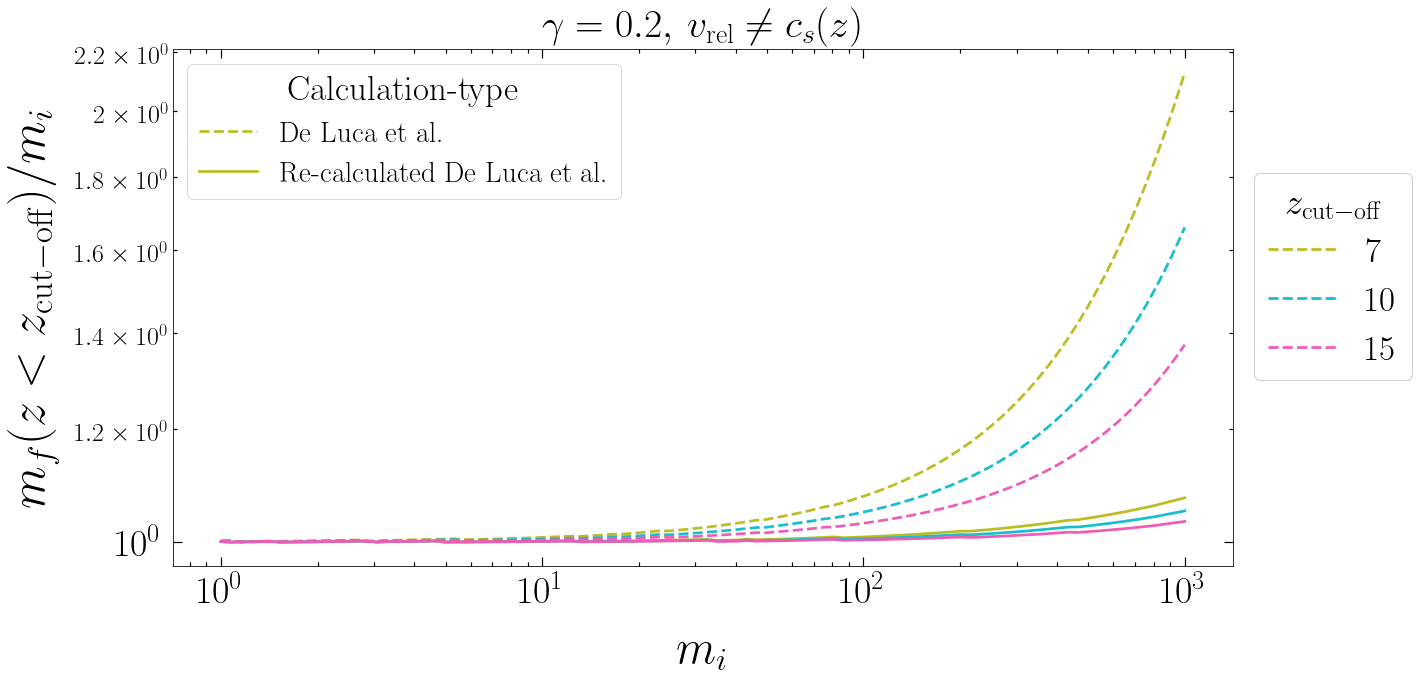

In [4]:
# Baryon accretion as per as per eq. (10) and (11) of Luca et. al https://arxiv.org/pdf/2003.12589.pdf 
# to upto z_cut-off = 5.
# Here, m_f(z < z_cut-off)/m_i implies  m_f(z = z_cut-off)/m_i.

m_spacing = 100
mi_arr = np.geomspace(1, 1e3, m_spacing)





fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_cut_arr = np.array([7, 10, 15])
mf_arr_Luca = np.zeros(len(mi_arr))
mf_arr_Luca_modified = np.zeros(len(mi_arr))
colors = ['C8', 'C9',  '#f15bb5']
plot_lines = []
N = 10



for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    speed_of_sound = True
    v_relative != speed_of_sound
    for j, m in enumerate(mi_arr):
        γ = 0.2
        z_1i = z_pbh(m,  γ)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        De_Luca = True
        sol1_Luca = solve_ivp(f, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        De_Luca = False
        sol1_Luca_modified = solve_ivp(f, t_span = [t1[0], t1[-1]], y0 = [y_1i], method = 'DOP853',  t_eval = t1)
        t1 = sol1_Luca.t
        y1_Luca = sol1_Luca.y[0]
        y1_Luca_modified = sol1_Luca_modified.y[0]


        z_2i = z_eq
        y_2i_Luca = y1_Luca[-1]
        y_2i_Luca_modified = y1_Luca_modified[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        De_Luca = True
        sol2_Luca = solve_ivp(f, t_span = [t2[0], t2[-1]], y0 = [y_2i_Luca], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        De_Luca = False
        sol2_Luca_modified = solve_ivp(f, t_span = [t2[0], t2[-1]], y0 = [y_2i_Luca_modified], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2_Luca.t
        y2_Luca = sol2_Luca.y[0]
        y2_Luca_modified = sol2_Luca_modified.y[0]




        z_3i = z_rec
        y_3i_Luca = y2_Luca[-1]
        y_3i_Luca_modified = y2_Luca_modified[-1]
        z_cut_off3 = z_th
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        De_Luca = True
        sol3_Luca = solve_ivp(f, t_span = [t3[0], t3[-1]], y0 = [y_3i_Luca], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        De_Luca = False
        sol3_Luca_modified = solve_ivp(f, t_span = [t3[0], t3[-1]], y0 = [y_3i_Luca_modified], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        t3 = sol3_Luca.t
        y3_Luca = sol3_Luca.y[0]
        y3_Luca_modified = sol3_Luca_modified.y[0]
        
        
        
        z_4i = z_th
        y_4i_Luca = y3_Luca[-1]
        y_4i_Luca_modified = y3_Luca_modified[-1]
        z_cut_off4 = 90
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        De_Luca = True
        sol4_Luca = solve_ivp(f, t_span = [t4[0], t4[-1]], y0 = [y_4i_Luca], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        De_Luca = False
        sol4_Luca_modified = solve_ivp(f, t_span = [t4[0], t4[-1]], y0 = [y_4i_Luca_modified], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        t4 = sol4_Luca.t
        y4_Luca = sol4_Luca.y[0]
        y4_Luca_modified = sol4_Luca_modified.y[0]

        
        
        
        z_5i = z_cut_off4
        y_5i_Luca = y4_Luca[-1]
        y_5i_Luca_modified = y4_Luca_modified[-1]
        z_cut_off5 = z_cut
        t5 = np.geomspace(z_5i, z_cut_off5, N)
        t_span = [t5[0], t5[-1]]
        De_Luca = True
        sol5_Luca = solve_ivp(f, t_span = [t5[0], t5[-1]], y0 = [y_5i_Luca], method = 'DOP853',  t_eval = t5, first_step = 1, max_step = 3)
        De_Luca = False
        sol5_Luca_modified = solve_ivp(f, t_span = [t5[0], t5[-1]], y0 = [y_5i_Luca_modified], method = 'DOP853',  t_eval = t5, first_step = 1, max_step = 3)
        t5 = sol5_Luca.t
        y5_Luca = sol5_Luca.y[0]
        y5_Luca_modified = sol5_Luca_modified.y[0]
        
        
        mf_arr_Luca[j] = y5_Luca[-1]
        mf_arr_Luca_modified[j] = y5_Luca_modified[-1]

    
    ax.loglog(mi_arr, np.divide(mf_arr_Luca, mi_arr), color = color, ls = '--')
    ax.loglog(mi_arr, np.divide(mf_arr_Luca_modified, mi_arr), color = color)
    
        
        
       
    
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$m_{i}$',fontsize = 47, labelpad = 20)

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["De Luca et al.", "Re-calculated De Luca et al."], title = 'Calculation-type',
        title_fontsize = 35, loc = 'upper left', prop = {"size":29})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 37, loc = (1.02, 0.36), prop = {"size":35})

ax.add_artist(legend1)
ax.add_artist(legend2)


plt.ylabel(r'$m_{f}(z < z_\mathrm{cut-off})/m_{i} $',fontsize = 50, labelpad = 16)
plt.xscale('log')
plt.title(r'$\gamma = 0.2, \, v_\mathrm{rel} \neq c_{s}(z)$', fontsize = 40, pad = 13)
plt.savefig('Luca_z_diff_cutoff3.pdf', bbox_inches = 'tight')
plt.show()